In [1]:
from scipy.io.wavfile import read as wavread
fs, x_int16 = wavread('my_a.wav')
x = x_int16 / (2 ** 15 - 1)

E:\Anaconda\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [16]:
import pyworld as pw
_f0, t = pw.dio(x, fs)    # raw pitch extractor
f0 = pw.stonemask(x, _f0, t, fs)  # pitch refinement
sp = pw.cheaptrick(x, f0, t, fs)  # extract smoothed spectrogram
ap = pw.d4c(x, f0, t, fs)         # extract aperiodicity
y = pw.synthesize(f0, sp, ap, fs)

Please check "test" directory for output files


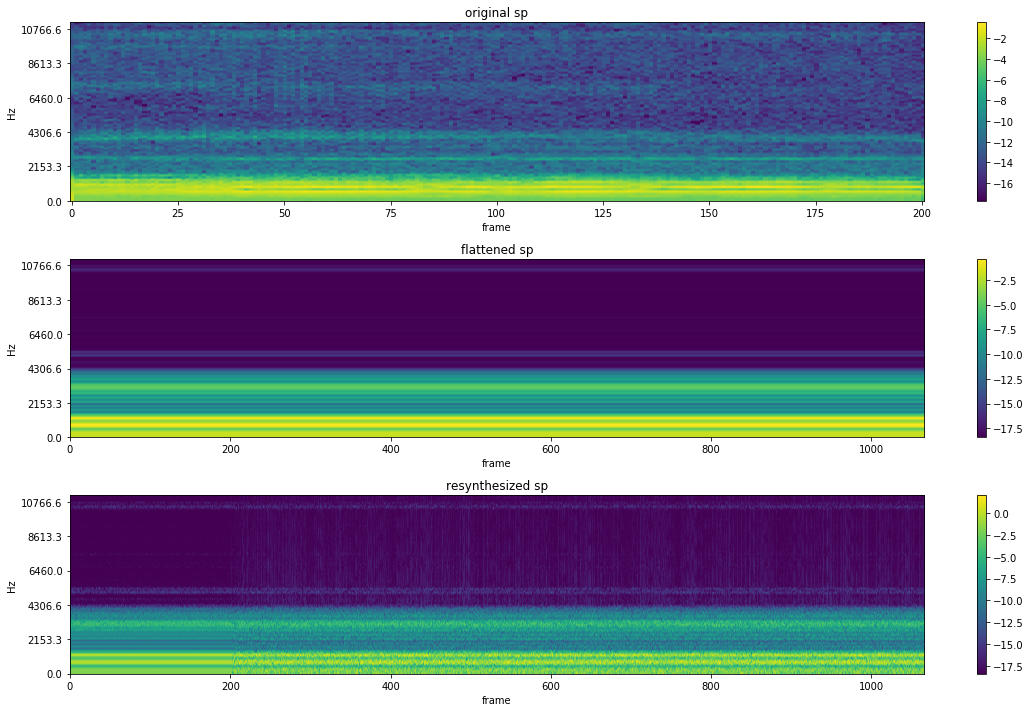

In [46]:
from __future__ import division, print_function

import os
from shutil import rmtree
import argparse

import numpy as np

import matplotlib      # Remove this line if you don't need them
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import soundfile as sf
# import librosa
import pyworld as pw


EPSILON = 1e-8
wavname = 'my_a'
wavname2 = 'a'

x, fs = sf.read(wavname+'.wav')
x2, fs2 = sf.read(wavname2+'.wav')

try:
    x = (x[:,0] + x[:,1])/2
except:pass

try:
    x2 = (x2[:,0] + x2[:,1])/2
except:pass
    
def savefig(figlist, title,log=True):
    #h = 10
    n = len(figlist)
    # peek into instances
    f = figlist[0]
    if len(f.shape) == 1:
        plt.figure()
        for i, f in enumerate(figlist):
            plt.subplot(n, 1, i+1)
            if len(f.shape) == 1:
                plt.plot(f)
                plt.xlim([0, len(f)])
    elif len(f.shape) == 2:
        plt.figure(figsize = (16,10))
        for i, f in enumerate(figlist):
            
            plt.subplot(n, 1, i+1, label='linear line')
            plt.title(title[i])
            plt.xlabel('frame')
            plt.ylabel('Hz')
            plt.yticks(np.arange(0,513,100),np.round(fs/1024.0*np.arange(0,513,50),1))
            if log:
                x = np.log(f + EPSILON)
            else:
                x = f + EPSILON
            plt.imshow(x.T, origin='lower', interpolation='none', aspect='auto')
            plt.colorbar()
            
    else:
        raise ValueError('Input dimension must < 3.')
    plt.tight_layout() #prevent plot overlapping
    return plt

    
    # plt.close()


frame_period = 10.0 # millisecond



# 1. A convient way
f0, sp, ap = pw.wav2world(x, fs, frame_period =  frame_period)    # use default options
f02, sp2, ap2 = pw.wav2world(x2, fs, frame_period =  frame_period)    # use default options

y = pw.synthesize(f0, sp, ap, fs, pw.default_frame_period)

_f02, t = pw.dio(x2, fs, f0_floor=50.0, f0_ceil=600.0,
                channels_in_octave=2,
                frame_period=frame_period)
_f02[:]= _f02[50]

_sp = pw.cheaptrick(x2, _f02, t, fs)
                       
_sp = _sp[50,:]*np.ones((_sp.shape[0],1)) 

# _sp[:,30:] = 0.0000001  #This cannot be zero

# for i in range(len(_sp)):
#     for j in range(_sp.shape[1]):
#         if _sp[i,j]<0.0005:
#             _sp[i,j] =  0.0000001


_ap = pw.d4c(x, _f02, t, fs)
# for i in range(len(f0)):
#     _f0[i] = _f0[i]*(1.0+2.0*i/len(f0)) 

_y = pw.synthesize(_f02, _sp, _ap, fs, frame_period)
sf.write('test/'+wavname+'.wav', _y, fs)

syn_sp = pw.cheaptrick(_y, _f02, t, fs)
# Comparison
plt = savefig( [ sp[:,:520],_sp[:,:520],syn_sp[:,:520]],['original sp','flattened sp','resynthesized sp'])
plt.savefig("test/sp_"+wavname)

print('Please check "test" directory for output files')



In [35]:
_f02.shape[0]

201

In [43]:
a = np.array([[1,2],[3,4],[5,6]])
print(a.shape)
b= a[1,:]*np.ones((a.shape[0],1)) 
print(b.shape)
print(a)
print(b)



(3, 2)
(3, 2)
[[1 2]
 [3 4]
 [5 6]]
[[3. 4.]
 [3. 4.]
 [3. 4.]]


In [ ]:
a[1,:]
